In [61]:
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from prophet import Prophet

In [72]:
ticker = 'XRP-USD'
start_date = '2022-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')
data = yf.download(tickers=ticker, start=start_date, end=end_date)
ticker_name = ticker.upper()

[*********************100%***********************]  1 of 1 completed


In [73]:
data['DateOrdinal'] = pd.to_datetime(data.index).map(pd.Timestamp.toordinal)
X = data[['DateOrdinal']]
y = data['Close']

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [75]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [76]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.2f}")

MSE: 2.49


In [77]:
future_date = datetime(2025, 5, 13)
future_date_ordinal = pd.to_datetime(future_date).toordinal()
future_pred = model.predict([[future_date_ordinal]])
print(f"Vorhergesagter Kurs am {future_date.date()}: {float(future_pred[0]):.2f}")

Vorhergesagter Kurs am 2025-05-13: 0.53


In [78]:
future_dates = pd.date_range(start=data.index[-1] + timedelta(days=1), periods=180, freq='D')
future_ordinals = future_dates.map(pd.Timestamp.toordinal).to_frame(name='DateOrdinal')
future_predictions = model.predict(future_ordinals).ravel()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [79]:
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Close': future_predictions
})

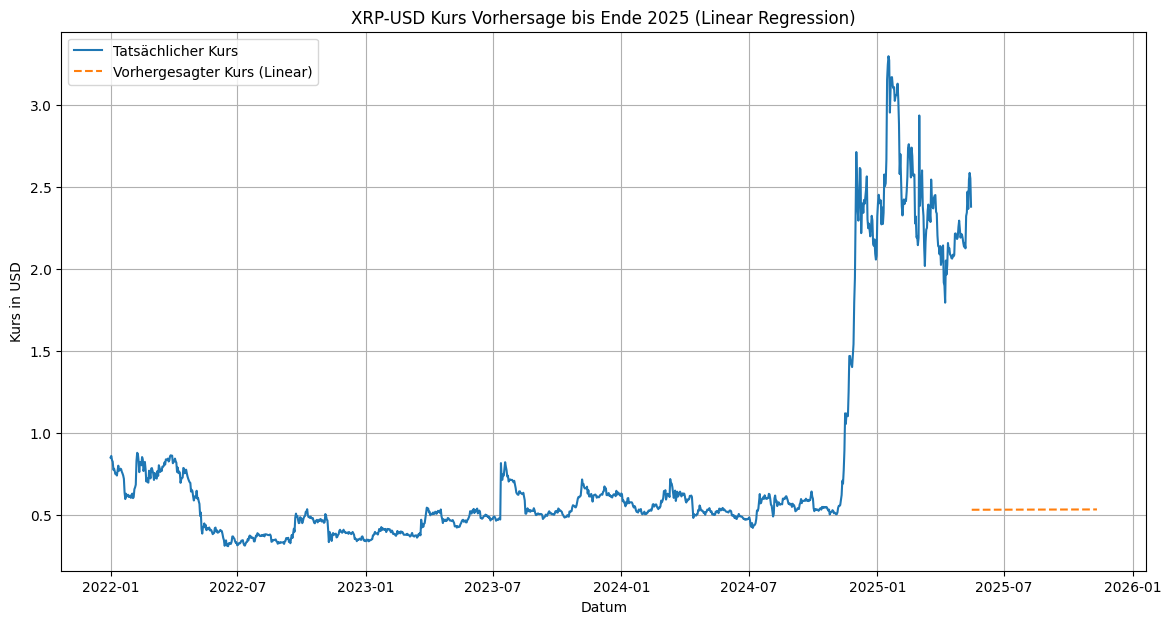

In [80]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Tatsächlicher Kurs')
plt.plot(future_df['Date'], future_df['Predicted Close'], label='Vorhergesagter Kurs (Linear)', linestyle='--')
plt.xlabel('Datum')
plt.ylabel('Kurs in USD')
plt.title(f'{ticker_name} Kurs Vorhersage bis Ende 2025 (Linear Regression)')
plt.legend()
plt.grid(True)
plt.show()

11:57:07 - cmdstanpy - INFO - Chain [1] start processing
11:57:07 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 0.98, 'Kursprognose für XRP-USD (Prophet)')

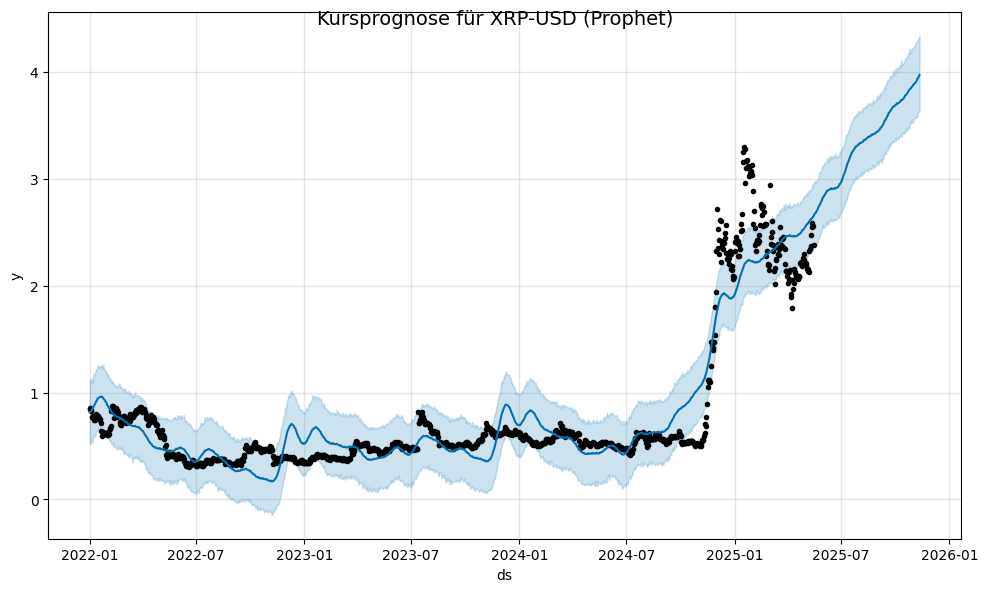

In [71]:
data = data.copy()
data.reset_index(inplace=True)

df_prophet = pd.DataFrame()
df_prophet['ds'] = data['Date']
df_prophet['y'] = data['Close'].astype(float) 

df_prophet.dropna(subset=['ds', 'y'], inplace=True)

prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(df_prophet)

future = prophet_model.make_future_dataframe(periods=180)
forecast = prophet_model.predict(future)

fig = prophet_model.plot(forecast)
fig.suptitle(f'Kursprognose für {ticker.upper()} (Prophet)', fontsize=14)